In [1]:
import pandas as pd
import numpy as np
import os

from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, get_body
import astropy.units as u
from astroplan import moon_illumination
from astropy.time import Time, TimeDelta

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import imageio.v2 as imageio

In [2]:
# Observation location, lat, long, elevation, min alt, mag limit
BPO = [51.372840, -2.319224, 200, 30, 12]

# Observation Window
start_date = "2025-10-01T18:00:00"
end_date   = "2025-10-31T06:00:00"

#The Varible stars from Monson paper
Monson_RRL =["SW And", "XX And", "WY Ant", "X Ari", "ST Boo", "UY Boo", "RR Cet", "W Crt", "UY Cyg", "XZ Cyg", "DX Del", "SU Dra", "SW Dra", "RX Eri", "SV Eri", "RR Gem", "TW Her", "VX Her", "SV Hya", "V Ind", "RR Leo", "TT Lyn", "RR Lyr", "RV Oct", "UV Oct", "AV Peg", "BH Peg", "BB Pup", "HK Pup", "RU Scl", "AN Ser", "V0440 Sgr", "V0675 Sgr", "AB UMa", "RV UMa", "TU UMa", "UU Vir", "AE Boo", "TV Boo", "ST CVn", "UY Cam", "YZ Cap", "RZ Cep", "RV CrB", "CS Eri", "BX Leo", "DH Peg", "RU Psc", "SV Scl", "AP Ser", "T Sex", "MT Tel", "AM Tuc", "SX UMa", "CU Com"]

# Finding targets

In [3]:
def Get_GAIA_RRL(site, query=False):

    if query:
        dec_min = site[0] - (90 - site[3])
        dec_max = site[0] + (90 - site[3])
        dec_max = min(dec_max, 90.0)

        ADQL = f"""
        SELECT  rr.source_id, gs.ra, gs.dec,
            gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag,
            rr.pf, rr.best_classification
        FROM gaiadr3.vari_rrlyrae AS rr
        JOIN gaiadr3.gaia_source AS gs
        ON rr.source_id = gs.source_id
        WHERE gs.dec BETWEEN {dec_min:} AND {dec_max:}
            AND gs.phot_bp_mean_mag <= {site[4]}
        """
    
        job = Gaia.launch_job_async(ADQL)
        results = job.get_results()
        results.write("data/vari_rrlyrae.csv", format="csv", overwrite=True)

    RRL = pd.read_csv("data/vari_rrlyrae.csv")
    RRL.rename(columns={'source_id': 'main_id'}, inplace=True)
    
    return RRL

In [4]:
def visabliity(df, site, start_date, end_date, dt_minutes=10.0, sun_night_threshold=-12.0, rename=False, save=True):

    # Time grid
    tstart = Time(start_date)
    tend = Time(end_date)

    # Creates an array of times with intervals of df mins
    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Location and ref frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # Sun altitude and night mask
    sun_altitudes = get_sun(times).transform_to(frame).alt.deg
    is_night = sun_altitudes < sun_night_threshold

    # No night in interval, stops function
    if not np.any(is_night):
        filtered_df = df.iloc[0:0].copy()
        if return_visibility_hours:
            return filtered_df, {}
        return filtered_df
    
    # Making sure ra/dec are plain numpy arrays
    ra = np.asarray(df["ra"].values, dtype=float)
    dec = np.asarray(df["dec"].values, dtype=float)

    # Coords of the stars in ra/dec then converted to alt/az
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    altaz = coords[:, None].transform_to(frame) 
    altitudes = altaz.alt.deg.T    # Height in the sky

    # Apply night mask, only times at night
    night_altitudes = altitudes[is_night, :]

    # True if any time in night  time altitudes >= min altitude
    meets_alt = np.any(night_altitudes >= site[3], axis=0)

    # Compute hours visible for every star (even 0) so we can add to df
    dt_hours = dt_minutes / 60.0
    hours_per_star = np.sum(night_altitudes >= site[3], axis=0) * dt_hours

    # Attach hours to the original df and select rows where the star is visable
    df["hours_visible"] = hours_per_star
    filtered_df = df.loc[hours_per_star > 0].reset_index(drop=True)
    
    filtered_df['main_id'] = filtered_df['main_id'].astype(str) 

    if rename:
        Simbad.add_votable_fields("ids")
        for i, gaia_id in enumerate(filtered_df["main_id"]):
            result = Simbad.query_object(f"Gaia DR3 {gaia_id}")
            if result is not None and len(result) > 0:
                aliases = result["ids"][0].split("|")
                nice_name = None
                for alias in aliases:
                    alias = alias.strip()
                    if alias.startswith("V* "):
                        nice_name = alias[3:]  # Getting rid of V*
                        break
                if nice_name:    # Only overwrite if a nice name was found
                    filtered_df.loc[i, "main_id"] = nice_name
                else:
                    filtered_df.loc[i, "main_id"] = result["main_id"][0]

    if save: filtered_df.to_csv('data/RRL_targets.csv', index=False)

    return filtered_df

In [5]:
# Takes a while so just reading in the csv file thats these produce is faster
"""
# Getting candidate stars by declination/flux prefilter
candidates = Get_GAIA_RRL(BPO, query=True)

# Filtering by visabliity during timeframe
RRL = visabliity(candidates, BPO, start_date, end_date, rename=True, save=True)
"""

'\n# Getting candidate stars by declination/flux prefilter\ncandidates = Get_GAIA_RRL(BPO, query=True)\n\n# Filtering by visabliity during timeframe\nRRL = visabliity(candidates, BPO, start_date, end_date, rename=True, save=True)\n'

In [6]:
maybe_RRL_targets = pd.read_csv("data/RRL_targets.csv")

# Restrict to Monson list
RRL = maybe_RRL_targets[maybe_RRL_targets["main_id"].isin(Monson_RRL)].reset_index(drop=True)

# Print the filtered DataFrame including the hours visible, sorted by hours descending
print("Stars that appear above 30° during night in the interval (sorted by hours_visible):")
print(RRL[["main_id", "ra", "dec", "hours_visible"]].sort_values("hours_visible", ascending=False).to_string(index=False))

Stars that appear above 30° during night in the interval (sorted by hours_visible):
main_id         ra       dec  hours_visible
 SW Dra 184.443944 69.510588     328.000000
 UY Cam 119.745316 72.787533     328.000000
 RZ Cep 339.805873 64.859351     327.833333
 SW And   5.929506 29.400923     288.166667
 RU Psc  18.608950 24.415476     285.833333
 SU Dra 174.485330 67.329393     229.833333
 XZ Cyg 293.122787 56.388085     218.833333
 BH Peg 343.254208 15.787665     210.666667
 AV Peg 328.011712 22.574789     196.666667
 UY Cyg 314.117903 30.427828     187.000000
 RR Lyr 291.365640 42.783489     171.333333
 DH Peg 333.856936  6.822620     167.000000
 RR Cet  23.034104  1.341534     158.500000
 RR Gem 110.389712 30.883189     144.500000
 DX Del 311.868209 12.464110     139.166667
 TT Lyn 135.781920 44.585400     127.333333
 TW Her 268.630021 30.410456      96.000000
 SX UMa 201.555538 56.256964      70.166667
 RV UMa 203.325143 53.987198      54.166667
 RV CrB 244.857596 29.713114      46

# Plotting airmass
#### (Need to update to proper way)

In [7]:
def plot_star_path(df, names, site, start_date, end_date, dt_minutes=30.0):
    
    # Select stars
    plot_stars = df[df["main_id"].isin(names)]
    if plot_stars.empty: raise ValueError("No matching stars found in data frame")

    # Build time array from start_date to end_date with steps of dt_minutes
    tstart = Time(start_date)
    tend = Time(end_date)
    if tend <= tstart: raise ValueError("end_date must be after start_date")

    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Observer frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # Sun altitudes for shading
    sun_altitudes = get_sun(times).transform_to(frame).alt.deg

    plt.figure(figsize=(12,6))
    ax = plt.gca()

    # Colours depending on sunlight
    sky_shade = {"daylight": "#ffffcc", "civil": "#ffe6cc", "nautical": "#e6f2ff", "astronomical": "#e6e6ff", "night": "#d9d9d9"}

    # Shade background by sun altitude bands
    for i in range(len(times) - 1):
        alt = sun_altitudes[i]
        t0 = times[i].plot_date
        t1 = times[i+1].plot_date

        if alt > 0: shade = sky_shade["daylight"]
        elif alt > -6: shade = sky_shade["civil"]
        elif alt > -12: shade = sky_shade["nautical"]
        elif alt > -18: shade = sky_shade["astronomical"]
        else: shade = sky_shade["night"]

        ax.axvspan(t0, t1, color=shade)    #setting that section of the graph to the corresponding colour

    # Compute alt/az for all selected stars at once
    ra = np.asarray(plot_stars["ra"].values, dtype=float)
    dec = np.asarray(plot_stars["dec"].values, dtype=float)
    coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    
    # transform to alt/az coord system and find the airmass
    altaz = coords[:, None].transform_to(frame)
    airmass = altaz.secz.T    # T for transpose to make plotting easier

    # Stops stars that are below the horizon as secz returns nan for these
    airmass = np.where(altaz.alt.deg.T > 0, altaz.secz.T, np.nan)

    # Plot each star's altitude track
    for col_idx, name in enumerate(plot_stars["main_id"].values):
        plt.plot(times.plot_date, airmass[:, col_idx], label=name)

    # Formatting
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%m-%Y\n%H:%M"))
    plt.ylabel("Altitude (deg)")
    plt.xlabel("Time")
    plt.ylabel("Airmass")
    plt.ylim(1, 5)
    plt.legend(loc="best", fontsize="small", ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

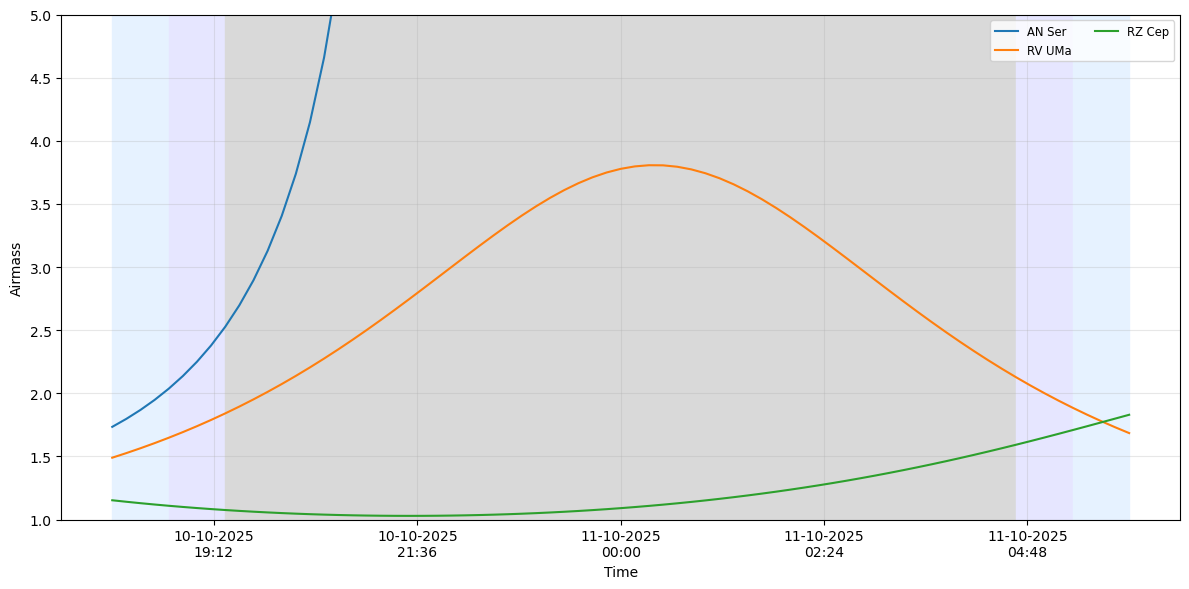

In [8]:
plot_stars = ["RV UMa", "RZ Cep", "AN Ser"]
#plot_stars = RRL['main_id'].to_list()    # Stars found through SIMBAD

# Plot star paths during a window
plot_star_path(RRL, plot_stars, BPO, start_date="2025-10-10T18:00:00", end_date="2025-10-11T06:00:00", dt_minutes=10)

# Standard stars

In [9]:
# Reading in a file containing info about landolt standard stars in the northen hemisphere
All_SS = pd.read_csv("data/landolt_north.csv",delimiter = "|")
All_SS.columns = ['oid', 'main_id', 'ra', 'dec']

# Filter using the same method as the RRl stars
SS = visabliity(All_SS, BPO, start_date, end_date, save=False)

In [10]:
def match_to_standards(vars_df, stds_df, save):
    
    # Ensure numeric arrays
    vars_ra = np.asarray(vars_df["ra"].values, dtype=float)
    vars_dec = np.asarray(vars_df["dec"].values, dtype=float)
    stds_ra = np.asarray(stds_df["ra"].values, dtype=float)
    stds_dec = np.asarray(stds_df["dec"].values, dtype=float)

    # Build SkyCoord objects
    coords_vars = SkyCoord(ra=vars_ra * u.deg, dec=vars_dec * u.deg)
    coords_stds = SkyCoord(ra=stds_ra * u.deg, dec=stds_dec * u.deg)

    # Match each variable to the nearest standard star
    idx, sep2d, _ = coords_vars.match_to_catalog_sky(coords_stds)

    # Build result DataFrame
    result = vars_df.copy().reset_index(drop=True)
    result["matched_standard"] = stds_df.iloc[idx]["main_id"].values
    result["standard_ra"] = stds_df.iloc[idx]["ra"].values
    result["standard_dec"] = stds_df.iloc[idx]["dec"].values
    result["sep_arcsec"] = sep2d.arcsec

    if save: result.to_csv('data/matched_targets.csv', index=False)

    return result

In [17]:
# Find nearest standard for every RRL
matched = match_to_standards(RRL, SS, save=True)

# Show results
matched

,main_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pf,best_classification,hours_visible,matched_standard,standard_ra,standard_dec,sep_arcsec
0,T Sex,148.368250,2.057213,10.031117,10.197908,9.725817,NaN,RRc,6.666667,KUV 10022+3901,151.291169,38.770887,132518.566389
1,TU UMa,172.451684,30.067090,9.799874,10.049275,9.417738,0.557669,RRab,22.000000,UCAC4 641-047820,172.358300,38.103332,28931.806592
2,AN Ser,238.379390,12.961102,11.032850,11.229733,10.569268,0.522066,RRab,1.000000,UCAC4 612-053329,251.846769,32.393655,82851.673985
3,TW Her,268.630021,30.410456,11.392736,11.572317,10.945030,0.399609,RRab,96.000000,GD 363,264.648592,41.875329,42852.017845
4,DX Del,311.868209,12.464110,9.913660,10.211061,9.484178,0.472617,RRab,139.166667,GD 391,307.484082,39.225611,97350.373094
5,RU Psc,18.608950,24.415476,10.129585,10.313169,9.779341,0.390316,RRab,285.833333,GD 8,9.967358,31.541426,37560.495613
6,BX Leo,174.508470,16.543327,11.561305,11.697940,11.260345,NaN,RRc,3.500000,UCAC4 641-047820,172.358300,38.103332,77913.586621
7,TV Boo,214.152398,42.359770,11.006255,11.116195,10.724413,NaN,RRc,16.333333,TYC 3042-267-1,218.085790,42.506685,10463.576315
8,RR Lyr,291.365640,42.783489,7.618804,7.831135,7.257368,0.566773,RRab,171.333333,UCAC4 676-066011,282.692321,45.098044,23962.273468
9,RV CrB,244.857596,29.713114,11.387015,11.528846,11.087021,NaN,RRc,46.833333,UCAC4 612-053329,251.846769,32.393655,23609.625240


# Moon phase

In [18]:
def plot_moon_illumination(start_date, end_date, dt_minutes=10.0):
    tstart = Time(start_date)
    tend = Time(end_date)
    n_minutes = int(np.ceil((tend - tstart).to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Moon illumination at each time
    illumination = moon_illumination(times)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(times.datetime, illumination * 100, color="k")
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d-%m-%Y\n%H:%M"))
    plt.ylabel("Moon Illumination (%)")
    plt.xlabel("Date and Time")
    plt.title("Moon Illumination Over Time")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

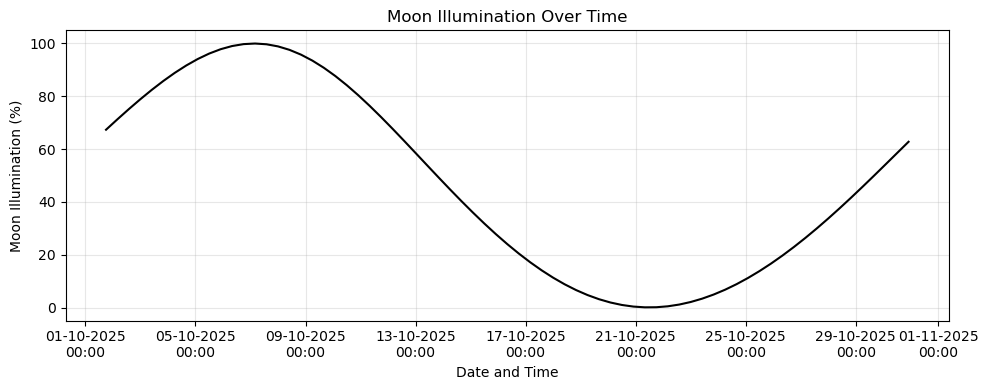

In [19]:
plot_moon_illumination(start_date, end_date, dt_minutes=600)

# Complete plots

In [20]:
def plot_night(star_name, matched_df, site, tstart, duration, dt_minutes=15.0, show=True, save=False):
    
    # Find the row for the requested star
    row = matched_df[matched_df["main_id"] == star_name]

    # Extract star info
    var_ra = row.iloc[0]["ra"]
    var_dec = row.iloc[0]["dec"]
    var_name = row.iloc[0]["main_id"]
    std_ra = row.iloc[0]["standard_ra"]
    std_dec = row.iloc[0]["standard_dec"]
    std_name = row.iloc[0]["matched_standard"]

    # Time grid
    tend = tstart + duration
    n_minutes = int(np.ceil(duration.to(u.min).value))
    times = tstart + np.arange(0, n_minutes + 1, dt_minutes) * u.min

    # Observer location and frame
    location = EarthLocation(lat=site[0]*u.deg, lon=site[1]*u.deg, height=site[2]*u.m)
    frame = AltAz(obstime=times, location=location)

    # SkyCoords
    var_coord = SkyCoord(ra=var_ra*u.deg, dec=var_dec*u.deg)
    std_coord = SkyCoord(ra=std_ra*u.deg, dec=std_dec*u.deg)

    # Moon SkyCoords and illumination
    moon_coord = get_body("moon", times, location).transform_to(frame)
    moon_illum = moon_illumination(times)

    # To AltAz
    var_altaz = var_coord.transform_to(frame)
    std_altaz = std_coord.transform_to(frame)

    # Filter for altitudes above horizon
    mask_var = var_altaz.alt > 0*u.deg
    mask_std = std_altaz.alt > 0*u.deg
    mask_moon = moon_coord.alt > 0*u.deg

    # Convert to polar coordinates
    az_var = var_altaz.az[mask_var].rad
    r_var = var_altaz.alt[mask_var].deg
    az_std = std_altaz.az[mask_std].rad
    r_std = std_altaz.alt[mask_std].deg
    az_moon = moon_coord.az[mask_moon].rad
    r_moon = moon_coord.alt[mask_moon].deg
    illum_moon = moon_illum[mask_moon]

    # Create polar plot
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(90, 0)  # Zenith at center, horizon at edge
    ax.grid(True, alpha=0.2)

    # ALt/Az label
    alt_ticks = np.arange(0, 100, 15)  # 0 to 90
    alt_labels = [f"{alt}°" for alt in alt_ticks]
    ax.set_rgrids(alt_ticks, labels=alt_labels, angle=20)
    ax.text(np.deg2rad(20), -10, "Altitude (deg)", ha="left", va="center", fontsize=10)
    ax.text(0, -8, "Azimuth (deg)", ha="center", va="bottom", fontsize=10)

    # Compass labels
    compass_labels = {"N": 0, "E": 90, "S": 180, "W": 270}
    for label, deg in compass_labels.items():
        angle_rad = np.deg2rad(deg)
        ax.text(angle_rad, -15, label, ha="center", va="center", fontsize=10, fontweight="bold")

    # Add date label to top-right corner of the plot
    date_str = "Night of observation: " + (tstart.datetime.strftime("%d.%m.%Y"))
    fig.text(0.05, 0.95, date_str, fontsize=10)

    # Shade region below minimum altitude
    ax.plot(np.linspace(0, 2*np.pi, 360), [site[3]]*360, color="gray", linestyle="--", linewidth=1)
    theta = np.linspace(0, 2*np.pi, 500)
    ax.fill_between(theta, site[3], 0, color="lightgray", alpha=0.4)

    # Plot paths
    ax.plot(az_var, r_var, color="blue", linewidth=2)
    ax.plot(az_std, r_std, color="green", linestyle="--")

    # Label star names
    if len(r_var) > 0:
        i_var_peak = np.argmax(r_var)
        ax.text(az_var[i_var_peak]+6, r_var[i_var_peak], var_name, color="blue", fontsize=9)
    if len(r_std) > 0:
        i_std_peak = np.argmax(r_std)
        ax.text(az_std[i_std_peak], r_std[i_std_peak]+5, std_name, color="green", fontsize=9)

    # Moon path with illumination shading
    moon_colors = plt.cm.Greys(illum_moon)
    ax.scatter(az_moon, r_moon, c=moon_colors, s=30)

    # Label moon illumination
    if len(r_moon) > 0:
        i_peak = np.argmax(r_moon)  # highest altitude
        illum_pct = int(illum_moon[i_peak] * 100)
        ax.text(az_moon[i_peak], r_moon[i_peak] - 10, f"Moon\n{illum_pct}%", fontsize=9)

    # Save and/or showing
    if save:
        fixed_name = star_name.replace(" ", "_")
        start_str = tstart.datetime.strftime("%Y-%m-%d_%H-%M")
        end_str = tend.datetime.strftime("%Y-%m-%d_%H-%M")
        filename = f"{fixed_name}_{start_str}_to_{end_str}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")

    if show: plt.show()
    else: plt.close()


In [21]:
def animate(star_name, start_night, nights, duration, output_folder="."):

    fixed_name = star_name.replace(" ", "_")     # Removes white space and V* start so can save as a file
    frames = []

    # Finding the saved images of the star and dates requested
    for night in range(nights):
        obs_start = start_night + TimeDelta(night, format="jd")
        obs_end = obs_start + duration
        start_str = obs_start.datetime.strftime("%Y-%m-%d_%H-%M")
        end_str = obs_end.datetime.strftime("%Y-%m-%d_%H-%M")
        filename = os.path.join(output_folder, f"{fixed_name}_{start_str}_to_{end_str}.png")
        if os.path.exists(filename):
            frames.append(imageio.imread(filename))
        else:
            print(f"Missing frame: {filename}")

    if not frames:
        print("No frames found — animation not created.")
        return
        
    # Create and save animation
    gif_name = f"{fixed_name}_animation.gif"
    gif_path = os.path.join(output_folder, gif_name)
    imageio.mimsave(gif_path, frames, duration=0.5)

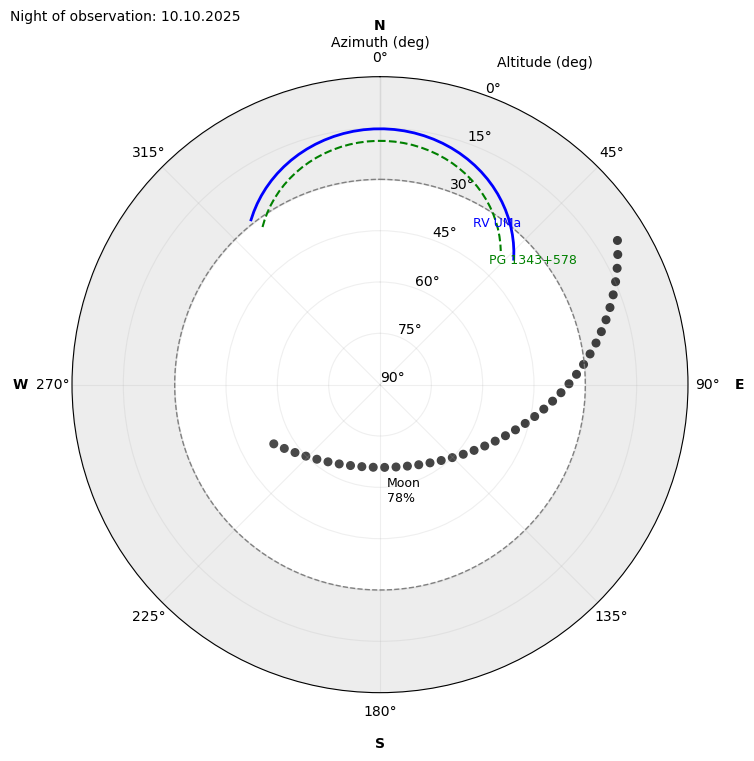

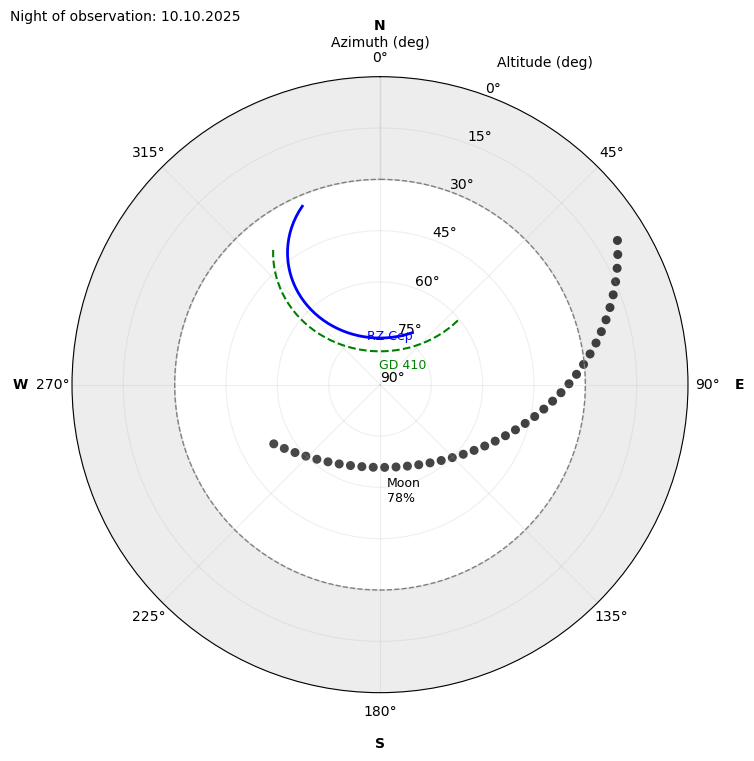

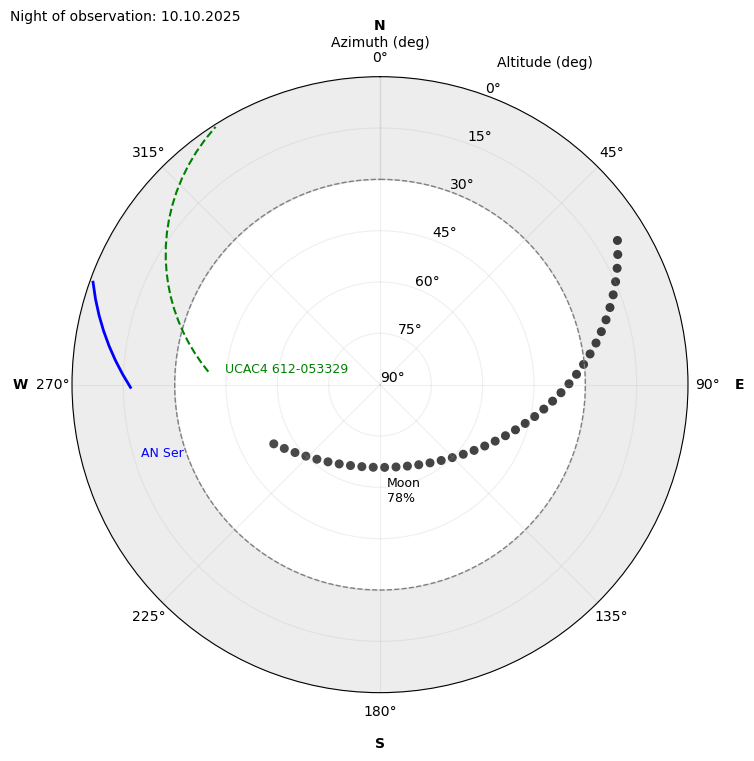

'\n#For one star across a time period\nVStar = "RZ Cep"\nnights = 10\nfor night in range(nights):\n    day = obs_start + TimeDelta(night, format="jd")\n    plot_night(VStar, matched, BPO, day, duration, show=False, save=True)\n\nanimate(VStar, obs_start, nights, duration)\n'

In [22]:
obs_start = Time("2025-10-10T20:00:00")
duration = TimeDelta(10 * 3600, format="sec") # 10 hours in seconds


plot_stars = ["RV UMa", "RZ Cep", "AN Ser"]
#plot_stars = matched["main_id"]

for VStar in plot_stars:
    plot_night(VStar, matched, BPO, obs_start, duration, show=True, save=False)

"""
#For one star across a time period
VStar = "RZ Cep"
nights = 10
for night in range(nights):
    day = obs_start + TimeDelta(night, format="jd")
    plot_night(VStar, matched, BPO, day, duration, show=False, save=True)

animate(VStar, obs_start, nights, duration)
"""
